<a href="https://colab.research.google.com/github/jacomyma/dtu-sts-material/blob/main/notebooks/colab/Visualize_by_issue_X_Filter_and_render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize by issue X - Filter and render

*DTU - Explore the Energy Islands controversy*

**Goal**:
- Filter the visualization using a condition (a **query**)
- Render the visualization as a static image
- You have 4 variations to choose from

**How to use**:
- Edit settings if you want
- Then use "Runtime > Run all" or execute from the edited cell and below
- Wait for each cell to run
- ⚠️ Allow the script to access your Google Drive data when prompted to.
- **Edit the query** as you see fit
- Re-run that cell and the following ones to update the visualizations


## Settings

In [ ]:
# SETTINGS (edit if necessary)
settings = {}
settings['issue'] = 1 # Issue number, from 1 to 16
settings['plot_width']  = 12 # In cm
settings['plot_height'] =  6 # In cm

## Code

(You don't have to understand what's going on here, but feel free to take a look)

In [ ]:
# Additional settings you shouldn't have to change
settings['statements_spreadsheet_drive_URL'] = 'https://docs.google.com/spreadsheets/d/1cSwVVXAB7kYRbGKEr6gc5IGs955dIfJNcCzyl_cywa8/edit?usp=drive_link'

### Install stuff
Note: already installed libraries will not be reinstalled, don't worry about re-running that.

In [ ]:
!pip install pandas gspread google-auth google-auth-oauthlib google-auth-httplib2

In [ ]:
# Import necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

### Load data from the corpus

In [ ]:
# Open the spreadsheet by its key or URL
spreadsheet_key = settings['statements_spreadsheet_drive_URL'].split('/d/')[1].split('/edit')[0]
sh = gc.open_by_key(spreadsheet_key)

# Select the worksheet
worksheet_name = 'dataset'
worksheet = sh.worksheet(worksheet_name)

In [ ]:
# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Create a Pandas DataFrame from the list of lists
df = pd.DataFrame(data[1:], columns=data[0])

# Set 'Year' column to int
df['Year'] = df['Year'].replace('', pd.NA)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(pd.Int64Dtype())

# Set 'X', 'Y' and 'Size' columns to float
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

print('Data loaded.')

Data loaded.


### Other prep we need

In [ ]:
attribute = f"Issue_{settings['issue']}"

In [ ]:
# Compute modalities
df_modalities_all = df[attribute].value_counts()

# Monitor
#df_modalities_all

In [ ]:
# This is the function we will use to visualize a matching condition
def visualize(condition, title='Proportion of filtered items'):
  # Make a copy of df
  df_copy = df.copy()

  # Mark each row of df_copy as filtered if the condition is fulfilled
  df_copy['filtered'] = condition

  # Plot a pie chart with counts and percentages
  filtered_counts = df_copy['filtered'].value_counts()

  def make_autopct(values):
      def my_autopct(pct):
          total = sum(values)
          val = int(round(pct*total/100.0))
          return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
      return my_autopct

  # Define the colors for True and False
  colors = ['#4deded' if label else '#EAEAEA' for label in filtered_counts.index]

  # Create a figure with a small size
  plt.figure(figsize=(3, 3))

  plt.pie(filtered_counts, autopct=make_autopct(filtered_counts), colors=colors, startangle=90)
  plt.title(title)
  plt.show()

# Filtering condition (QUERY)

**Edit the condition (the query)**, then run this cell and those below to update them. Also give a title to your query for clarity.

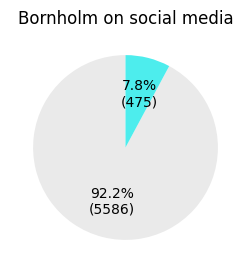

In [ ]:
# EDIT ME
condition = (
    (df['Statement'].str.contains('Bornholm', case=False, na=False))
  & (df['Source type'] == "Social media")
)

# EDIT ME (give an appropriate title to the query)
title = "Bornholm on social media"

# Check that it works
visualize(condition, title)

# Render the visualizations

## 1. Bar chart in absolute values, with context

PROs: Compares the query to the total. Comparable scales across different queries.

CONs: If the data volume is low, the pattern is too small to be visible, which also makes the small bars (low-volume categories) impossible to analyze.

Figure saved as 'Visualization 1.png'.


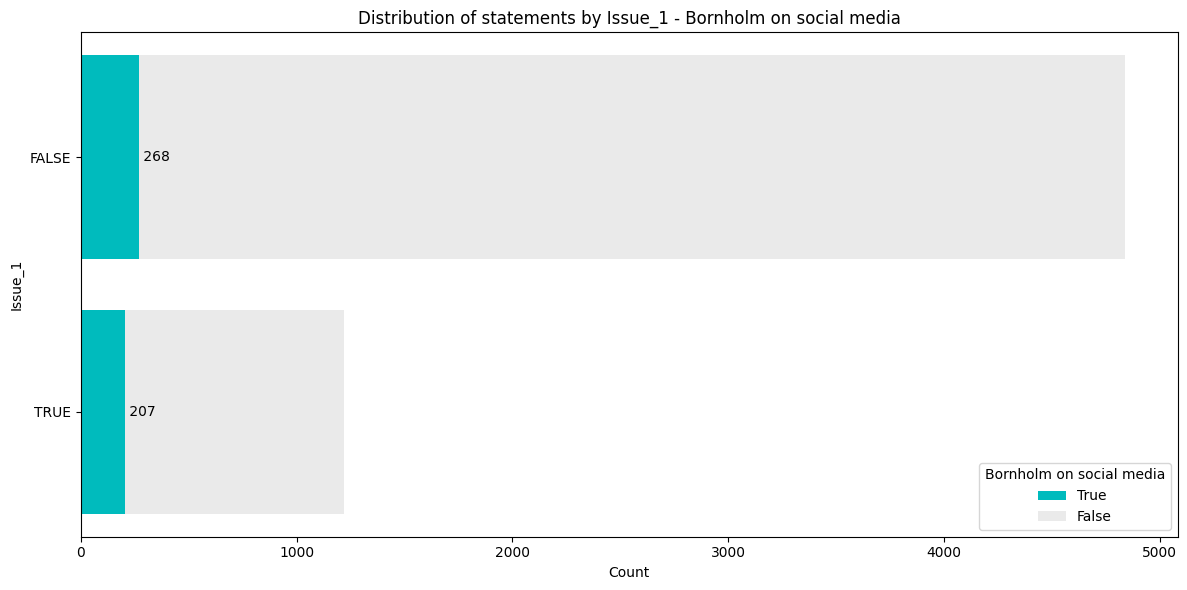

In [ ]:
# Get modalities list
df_modalities = df_modalities_all

# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Calculate value counts for 'True' and 'False' in 'filtered' column
actor_counts_true = df_[df_['filtered'] == True][attribute].value_counts()
actor_counts_false = df_[df_['filtered'] == False][attribute].value_counts()

# Calculate total counts and sort
total_counts = actor_counts_true.add(actor_counts_false, fill_value=0)
sorted_modalities = df_modalities[df_modalities.index.isin(total_counts.index)].index

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Plot bars for 'True' in blue using sorted modalities
plt.barh(sorted_modalities, actor_counts_true.reindex(sorted_modalities, fill_value=0), color='#00bbbd', label='True')
# Plot bars for 'False' in grey using sorted modalities, ensuring no overlap
plt.barh(sorted_modalities, actor_counts_false.reindex(sorted_modalities, fill_value=0), left=actor_counts_true.reindex(sorted_modalities, fill_value=0), color='#EAEAEA', label='False')

# Display counts on "True" bars
for i, v in enumerate(actor_counts_true.reindex(sorted_modalities, fill_value=0)):
    plt.text(v, i, ' '+str(v), va='center', color='black')

plt.xlabel('Count')
plt.ylabel(attribute)
plt.title(f"Distribution of statements by {attribute} - {title}")
plt.gca().invert_yaxis() # Invert y-axis to display largest value on top
plt.legend(title=title) # Display legend
plt.tight_layout()

# Save in 300dpi
filename = 'Visualization 1.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()

## 2. Bar chart in absolute values, no context

Same as above, except without the grey bars, and reordered.

PROs: Readable even when the general volume is low.

CONs: We can't compare to the total. We can't compare multiple queries, as they will have different scalings and a different bar order. The low-volume categories remain impossible to analyze.

Figure saved as 'Visualization 2.png'.


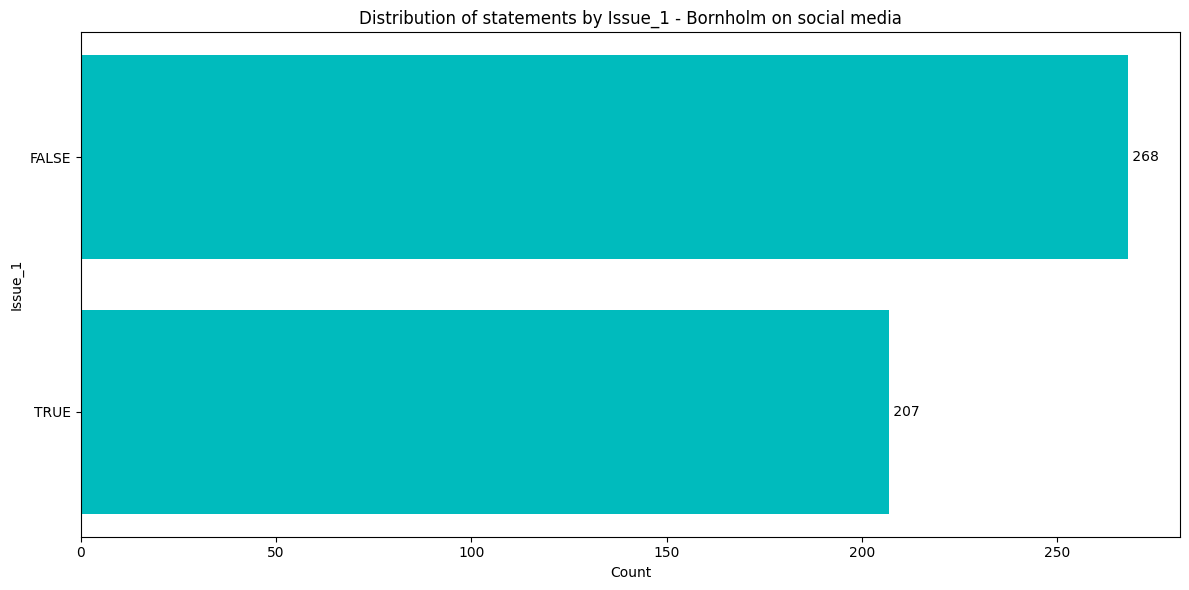

In [ ]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Calculate value counts for 'True' and 'False' in 'filtered' column
actor_counts_true = df_[df_['filtered'] == True][attribute].value_counts()
actor_counts_false = df_[df_['filtered'] == False][attribute].value_counts()

# Ignore modalities (actor_counts_true) with not enough statements
actor_counts_true = actor_counts_true[actor_counts_true.index.isin(df_modalities_all.index)]

# Calculate total counts and sort
sorted_modalities = actor_counts_true.sort_values(ascending=False).index

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Plot bars for 'True' in blue using sorted modalities
plt.barh(sorted_modalities, actor_counts_true.reindex(sorted_modalities, fill_value=0), color='#00bbbd', label='True')

plt.xlabel('Count')
plt.ylabel(attribute)
plt.title(f"Distribution of statements by {attribute} - {title}")
plt.gca().invert_yaxis() # Invert y-axis to display largest value on top
plt.tight_layout()

# Display counts on "True" bars
for i, v in enumerate(actor_counts_true.reindex(sorted_modalities, fill_value=0)):
    plt.text(v, i, ' '+str(v), va='center', color='black')

# Save in 300dpi
filename = 'Visualization 2.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()

## 3. Bar chart in percentages, with context

Instead of the absolute values, we plot the percentage of statements.

PROs: The percentage makes more sense in more situations, because it takes the context (total volume) into account. Compares the query to the total.

CONs: If the query is low-volume it may not be readable. Categories with very low volume get overrepresented.

Figure saved as 'Visualization 3.png'.


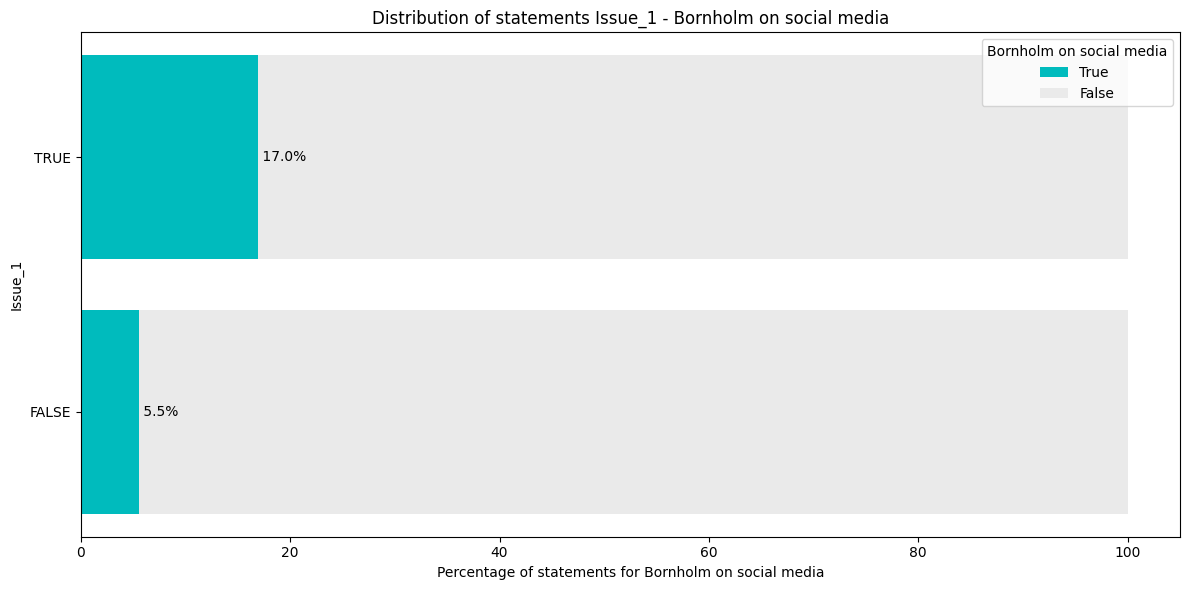

In [ ]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Group
statements = df_.groupby(attribute)['filtered'].value_counts().unstack(fill_value=0)

# Ignore modalities with not enough statements
statements = statements[statements.index.isin(df_modalities_all.index)]

# Compute percentages of True
statements['True%'] = statements[False]+statements[True]
statements['True%'] = 100*statements[True]/statements['True%']
statements['False%'] = 100-statements['True%']

# Sort
statements = statements.sort_values('True%', ascending=False)

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

try:
  plt.barh(statements.index, statements['True%'], color='#00BBBD', label='True')
  plt.barh(statements.index, statements['False%'], left=statements['True%'], color='#EAEAEA', label='False')
except:
  pass

# Display percentages on "True" bars
for i, v in enumerate(statements['True%']):
    plt.text(v, i, ' '+str(round(v, 1))+'%', va='center', color='black')

plt.xlabel(f"Percentage of statements for {title}")
plt.ylabel(attribute)
plt.title(f"Distribution of statements {attribute} - {title}")
plt.gca().invert_yaxis() # Invert y-axis to display largest value on top
plt.legend(title=title) # Display legend
plt.tight_layout()

# Save in 300dpi
filename = 'Visualization 3.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()

## 4. Bar chart in percentages, no context

Same as above but we adapt the X scale.

PROs: The percentage makes more sense in more situations. Always readable.

CONs: Categories with very low volume get overrepresented.

Figure saved as 'Visualization 4.png'.


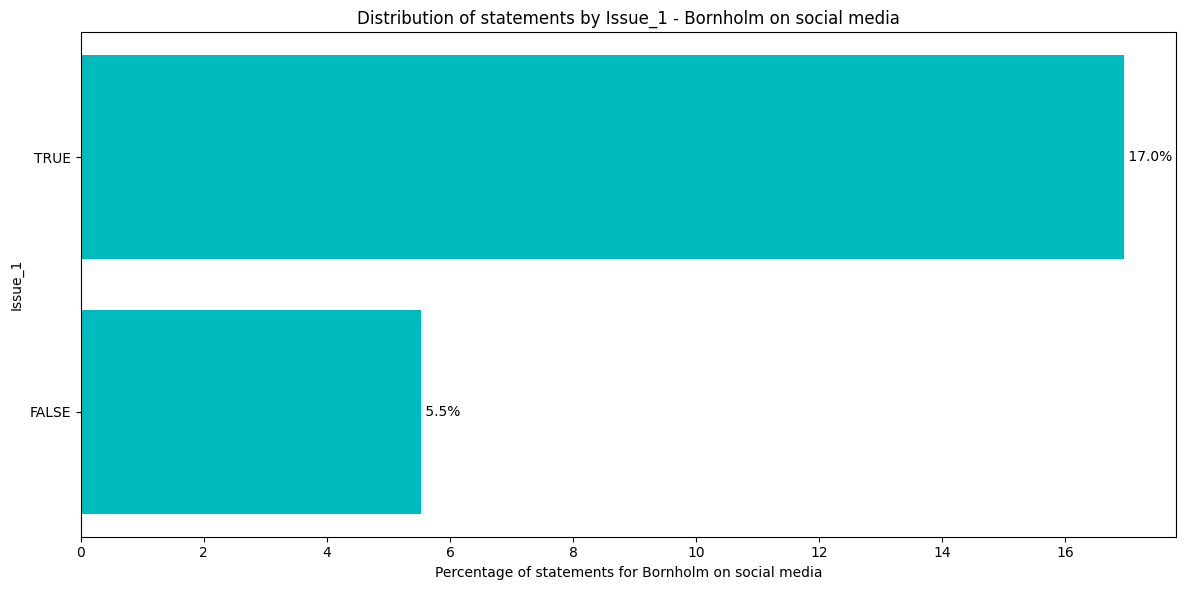

In [ ]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Group
statements = df_.groupby([pd.Grouper(key=attribute), 'filtered'])['filtered'].count().unstack(fill_value=0).reindex(columns=[False, True], fill_value=0)

# Ignore modalities with not enough statements
statements = statements[statements.index.isin(df_modalities_all.index)]

# Compute percentages of True
statements['True%'] = statements[False]+statements[True]
statements['True%'] = 100*statements[True]/statements['True%']
statements['False%'] = 100-statements['True%']

# Sort
statements = statements.sort_values('True%', ascending=False)

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

try:
  plt.barh(statements.index, statements['True%'], color='#00BBBD', label='True')
except:
  pass

# Display percentages on "True" bars
for i, v in enumerate(statements['True%']):
    plt.text(v, i, ' '+str(round(v, 1))+'%', va='center', color='black')

plt.xlabel(f"Percentage of statements for {title}")
plt.ylabel(attribute)
plt.title(f"Distribution of statements by {attribute} - {title}")
plt.gca().invert_yaxis() # Invert y-axis to display largest value on top
plt.tight_layout()

# Save in 300dpi
filename = 'Visualization 4.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()